In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import numpy as np
import scipy
from matplotlib import pyplot as plt

from harmonic_balance import aft, freq, utils

ndarray = np.ndarray

In [ ]:
NH = 4
n = 2
m1, m2 = 1, 2
c1, c2, c3 = 1, 0.5, 2
k1, k2, k3 = 1, 0.5, 2

M = np.diag([m1, m2])
C = np.array([[c1 + c2, -c2], [-c2, c2 + c3]])
K = np.array([[k1 + k2, -k2], [-k2, k2 + k3]])

omega = 2
t0, tf = tlim = 0, 2 * np.pi / omega
tn = NH * 2
tls = np.linspace(*tlim, tn)

In [ ]:
A = freq.get_A(NH, omega, M, C, K)

ks = (1, 1)
dofs = (0, 1)
is_cosines = (1, 0)
coefficients = (2, 1)
b_ext = freq.get_b_ext(NH, n, ks, dofs, is_cosines, coefficients)

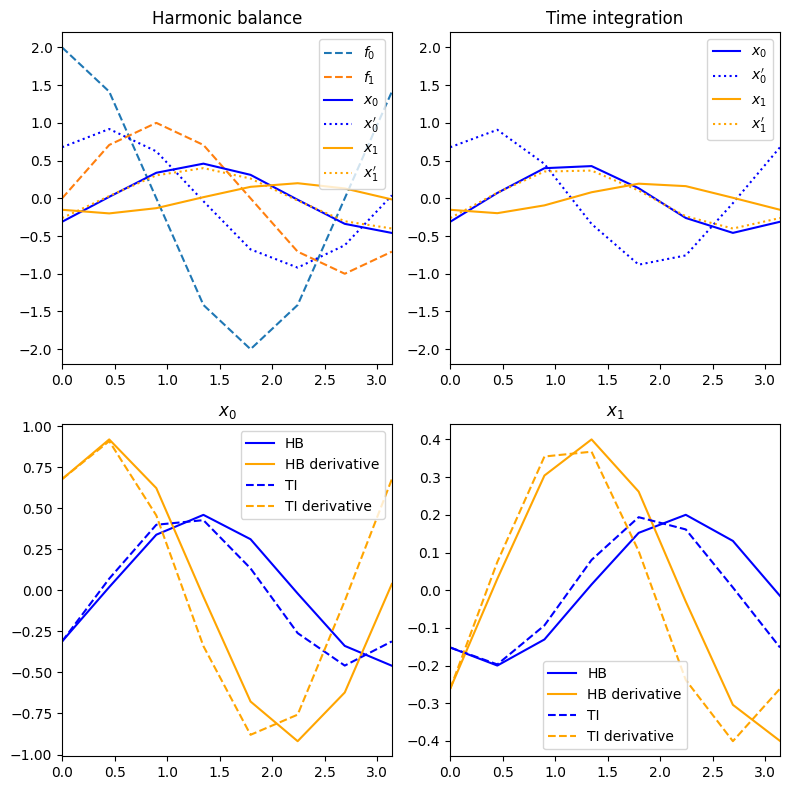

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
colors = ("blue", "orange")

ax = axs[0, 0]
ax.set_title("Harmonic balance")

bb_ext = utils.extract_dofs_freq(b_ext.toarray(), n)
ff = scipy.fft.irfft(bb_ext, axis=1, norm=freq.FFT_NORM)
names = [rf"f_{i}" for i in range(n)]
for f, color, name in zip(ff, colors, names):
    ax.plot(tls, f, label=f"${name}$", ls="--")

z = scipy.sparse.linalg.spsolve(A, b_ext)

zz = utils.extract_dofs_freq(z, n)
xx = scipy.fft.irfft(zz, axis=1, norm=freq.FFT_NORM)

derivative_factors = 1j * np.arange(NH + 1)
zzp = derivative_factors * zz * omega
xxp = scipy.fft.irfft(zzp, axis=1, norm=freq.FFT_NORM)

names = [rf"x_{i}" for i in range(n)]
for x, xp, color, name in zip(xx, xxp, colors, names):
    ax.plot(tls, x, color=color, label=rf"${name}$")
    ax.plot(tls, xp, color=color, label=rf"${name}'$", ls=":")
ax.legend()


ax = axs[0, 1]
ax.set_title("Time integration")

x0 = xx[:, 0]
xp0 = xxp[:, 0]
y0 = np.concat((x0, xp0))


def get_f(n, ks, dofs, is_cosines, coefficients):
    def f(omega, t):
        res = np.zeros(n)
        for k, dof, is_cosine, coefficient in zip(
            ks, dofs, is_cosines, coefficients
        ):
            if k == 0:
                res[dof] += coefficient
            elif is_cosine:
                res[dof] += coefficient * np.cos(k * omega * t)
            else:
                res[dof] += coefficient * np.sin(k * omega * t)
        return res

    return f


def ode(t, y, *args):
    omega, M, C, K, f = args

    x = y[:n]
    xp = y[n:]

    xpp = np.linalg.inv(M) @ (-C @ xp - K @ x + f(omega, t))
    return np.concat((xp, xpp))


args = (omega, M, C, K, get_f(n, ks, dofs, is_cosines, coefficients))
sol = scipy.integrate.solve_ivp(ode, tlim, y0, t_eval=tls, args=args)

xx_ti = sol.y[:n]
xxp_ti = sol.y[n:]

for x, xp, color, name in zip(xx_ti, xxp_ti, colors, names):
    ax.plot(tls, x, color=color, label=rf"${name}$")
    ax.plot(tls, xp, color=color, label=rf"${name}'$", ls=":")
ax.legend()
ax.set_ylim(axs[0, 0].get_ylim())


for i in range(n):
    ax = axs[1, i]
    ax.set_title(rf"${names[i]}$")
    ax.plot(tls, xx[i], color=colors[0], label="HB")
    ax.plot(tls, xxp[i], color=colors[1], label="HB derivative")
    ax.plot(tls, xx_ti[i], color=colors[0], label="TI", ls="--")
    ax.plot(tls, xxp_ti[i], color=colors[1], label="TI derivative", ls="--")
    ax.legend()

[ax.set_xlim(*tlim) for ax in axs.ravel()]

fig.tight_layout()
plt.show()

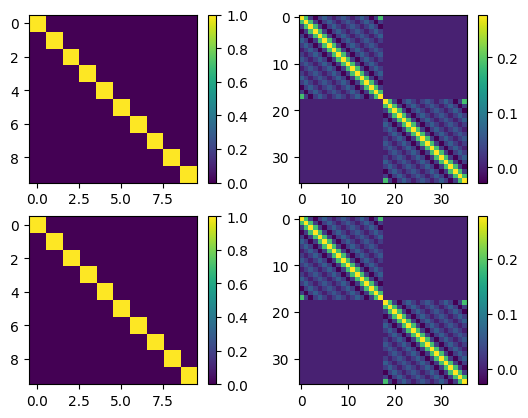

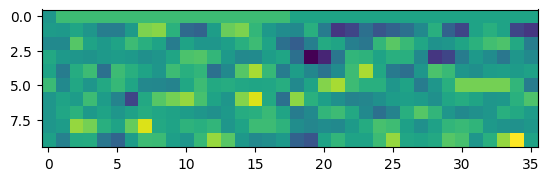

(np.float64(8.8164920776615475e-16), np.float64(4.320738988390518e-17))

In [ ]:
N = 18

gamma = aft.get_gamma(omega, NH, n, N)
inv_gamma = aft.get_inv_gamma(omega, NH, n, N)

fig, axs = plt.subplots(2, 2)
images = list()
images.append(axs[0, 0].imshow((np.linalg.pinv(gamma.toarray()) @ gamma).real))
images.append(axs[0, 1].imshow((gamma @ np.linalg.pinv(gamma.toarray())).real))
images.append(axs[1, 0].imshow((inv_gamma @ gamma).real.toarray()))
images.append(axs[1, 1].imshow((gamma @ inv_gamma).real.toarray()))
[fig.colorbar(image) for image in images]
plt.show()

plt.imshow((inv_gamma - np.linalg.pinv(gamma.toarray())).real)
plt.show()


(
    utils.max_abs(gamma @ inv_gamma @ gamma - gamma),
    utils.max_abs(inv_gamma @ gamma @ inv_gamma - inv_gamma),
)

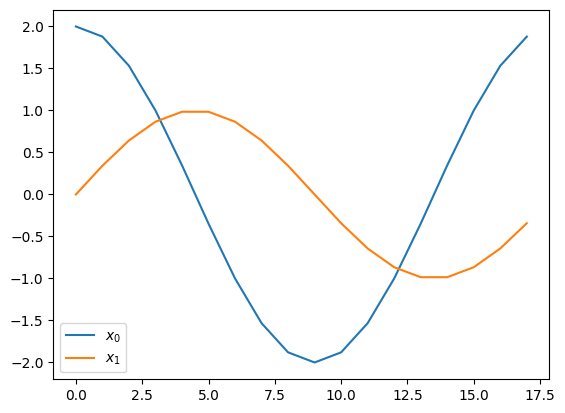

In [ ]:
time = aft.time_from_freq(n, gamma, b_ext)
x0, x1 = utils.extract_dofs_time(time.toarray(), n)
plt.plot(x0, label="$x_0$")
plt.plot(x1, label="$x_1$")
plt.legend()
plt.show()